## Credit Card Fraud Kaggle Project

Logistic Regression and a random forest model to predict fraudulent transactions on credit card data. 

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic
import math
import IPython
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [9]:

df = pd.read_csv("fraud_data.csv")

In [10]:
df

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,22-01-2019 00:37,Hudson-Grady,shopping_pos,122.00,Athena,OR,45.8289,-118.4971,1302,Dealer,18-10-1976,699a4c06b22711bf3e0d8ef91232d356,46.442439,-118.524214,0
14442,22-01-2019 00:41,"""Nienow, Ankunding and Collie""",misc_pos,9.07,Gardiner,OR,43.7857,-124.1437,260,"""Engineer, maintenance""",01-09-1956,080d620d24815c7d6c637cf0b71dde8e,42.901265,-124.995317,0
14443,22-01-2019 00:42,Pacocha-O'Reilly,grocery_pos,104.84,Alva,WY,44.6873,-104.4414,110,"""Administrator, local government""",16-05-1973,3c346c8cd627c5fe3ed57430db2e9ae7,45.538062,-104.542117,0
14444,22-01-2019 00:48,"""Bins, Balistreri and Beatty""",shopping_pos,268.16,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,e66ffcc95ba7fc490486242af1205d04,64.081462,-165.898698,0


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [12]:
#Value counts show that the data is imbalanced. Which is what would be expected for fraudulent activity.
df['is_fraud'].value_counts()

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

In [13]:
#Dropping the two observations that are not a 0 or 1 but also have a timestamp.
df = df[df['is_fraud'].isin(['1', '0'])]


In [14]:
#Deleting trans_num as it provides no information in the prediction of fraud.
del df['trans_num']

#### Feature Engineering

In [15]:
#Creating an age category
df['dob'][0]
df['age'] = (pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M") - 
             pd.to_datetime(df['dob'], format="%d-%m-%Y")).dt.days // 365

# Extracting the time of the day
df['trans_date_trans_time'][0]
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M")
df['time_of_day'] = df['trans_date_trans_time'].dt.strftime('%H:%M')

# Hour of Day
df['hour'] = df['trans_date_trans_time'].dt.hour

#Extracting day of the week.
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

#Create a new measure of the distance between lat and long and merchant lat and long
## Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371.0  # Radius of Earth in kilometers
    distance = r * c
    return distance
    
## Apply Haversine function row-wise
df['distance_km'] = df.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
    axis=1
)



In [16]:
#Creating job categories.
def job_categories(profession):
    profession_lower = profession.lower()
    
    # Education, Training, and Research
    if any(keyword in profession_lower for keyword in [
        'administrator, education', 'lecturer', 'teacher', 'professor', 'telecommunications researcher',
        'research scientist', 'education officer', 'learning mentor', 'teaching laboratory technician',
        'special educational needs', 'research officer', 'science writer', 'education administrator']):
        return 'Education, Training, and Research'
    
    # Healthcare, Therapy, and Well-being
    elif any(keyword in profession_lower for keyword in [
        'nurse', 'therapist', 'psychologist', 'counsellor', 'pharmacist', 'osteopath', 'chiropodist',
        'health', 'clinical', 'physiotherapist', 'medical', 'audiological', 'exercise physiologist',
        'music therapist', 'occupational therapist', 'podiatrist', 'occupational hygienist']):
        return 'Healthcare, Therapy, and Well-being'
    
    # Science, Engineering, and Technology
    elif any(keyword in profession_lower for keyword in [
        'cytogeneticist', 'scientist', 'engineer', 'geoscientist', 'geologist',
        'cartographer', 'soil scientist', 'water engineer', 'systems developer']):
        return 'Science, Engineering, and Technology'
    
    # Business, Finance, and Law
    elif any(keyword in profession_lower for keyword in [
        'solicitor', 'legal', 'accountant', 'tax inspector', 'investment banker', 'economist',
        'investment analyst', 'comptroller', 'financial', 'officer', 'sales', 'retail merchandiser',
        'manager', 'chief marketing officer', 'marketing executive', 'public relations', 'futures trader',
        'clothing/textile technologist', 'insurance broker', 'advertising account planner']):
        return 'Business, Finance, and Law'
    
    # Creative Arts, Design, and Media
    elif any(keyword in profession_lower for keyword in [
        'artist', 'set designer', 'web designer', 'glass blower', 'fashion designer', 'community arts worker',
        'editor', 'journalist', 'video editor', 'musician', 'commissioning editor', 
        'television', 'radio', 'media', 'production', 'designer', 'features editor']):
        return 'Creative Arts, Design, and Media'
    
    # Construction, Planning, and Environment
    elif any(keyword in profession_lower for keyword in [
        'architect', 'landscape architect', 'building surveyor', 'town planner',
        'planning and development', 'minerals surveyor', 'civil engineer',
        'historic buildings inspector', 'petroleum engineer', 'construction', 'surveyor, minerals',
        'land/geomatics surveyor', 'buyer, industrial', 'surveyor, land/geomatics', 'contractor',
        'surveyor, mining', 'metallurgist']):
        return 'Construction, Planning, and Environment'
    
    # Public Sector, Civil Service, and Government
    elif any(keyword in profession_lower for keyword in [
        'civil service', 'local government officer', 'immigration officer',
        'armed forces', 'charity officer', 'international aid', 'police', 'firefighter',
        'intelligence analyst', 'public librarian', 'administrator, local government']):
        return 'Public Sector, Civil Service, and Government'
    
    # IT and Information Systems
    elif any(keyword in profession_lower for keyword in [
        'network engineer', 'systems analyst', 'information officer', 'it consultant', 
        'information systems manager', 'developer']):
        return 'IT and Information Systems'

     # Pilot
    elif any(keyword in profession_lower for keyword in [
        'airline pilot', 'pilot, airline']):
        return 'Pilot'
    
    # Other
    else:
        return 'Other'

# Apply the function to the column 'job'
df['professions'] = df['job'].apply(job_categories)

In [17]:
#Transforming specific data into categorical variables.
df['merchant'] = df['merchant'].astype('category')
df['category'] = df['category'].astype('category')
df['city'] = df['city'].astype('category')
df['state'] = df['state'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df['professions'] = df['professions'].astype('category')
df['hour'] = df['hour'].astype('category')
df['is_fraud'] = df['is_fraud'].astype(int)

In [18]:
#Checking the variable types.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  14444 non-null  datetime64[ns]
 1   merchant               14444 non-null  category      
 2   category               14444 non-null  category      
 3   amt                    14444 non-null  float64       
 4   city                   14444 non-null  category      
 5   state                  14444 non-null  category      
 6   lat                    14444 non-null  float64       
 7   long                   14444 non-null  float64       
 8   city_pop               14444 non-null  int64         
 9   job                    14444 non-null  object        
 10  dob                    14444 non-null  object        
 11  merch_lat              14444 non-null  float64       
 12  merch_long             14444 non-null  float64       
 13  is_fra

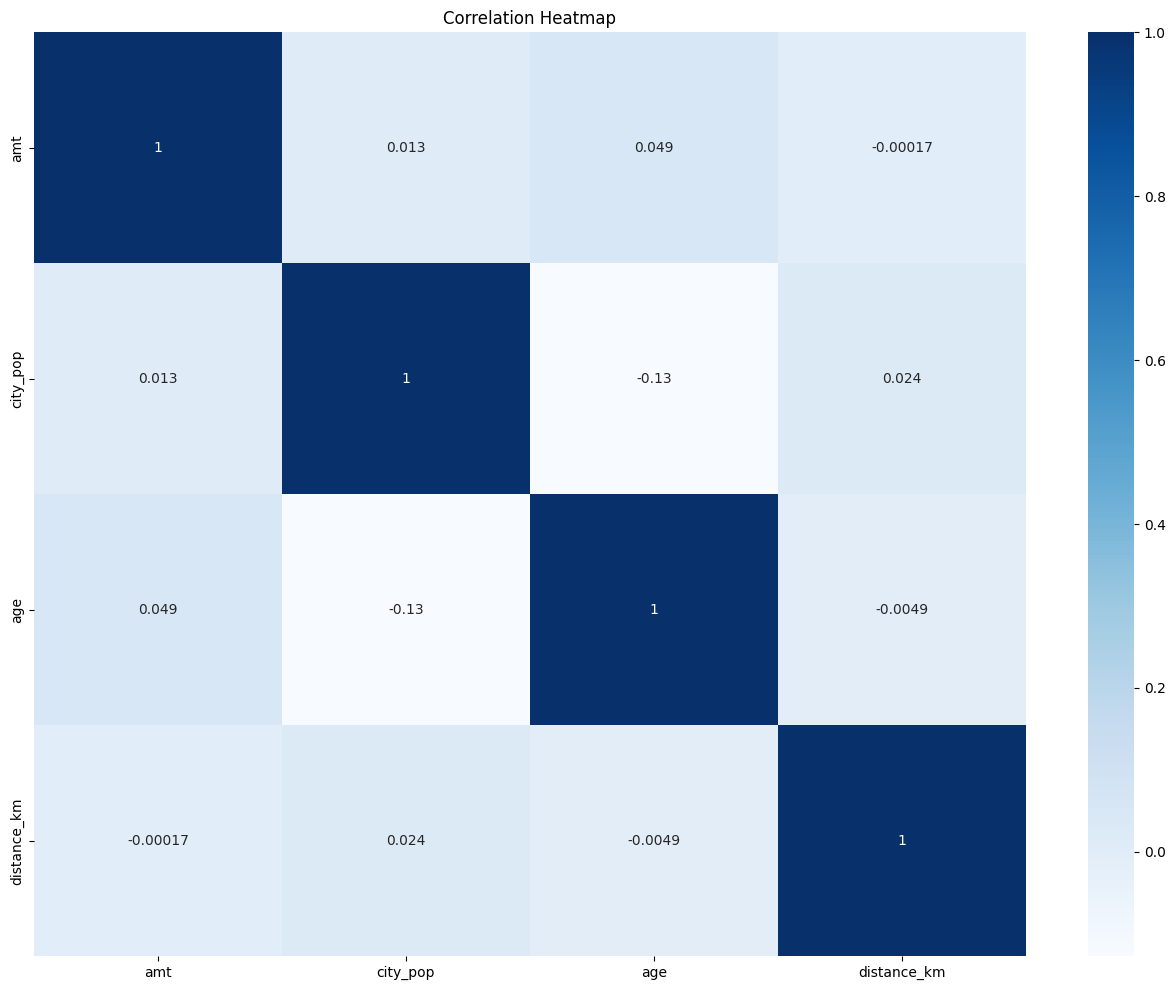

In [19]:
# The correlation matrix shows that the numeric data is not correlated.
quantdata = df[["amt", "city_pop", "age", "distance_km"]]
corr_matrix = quantdata.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [20]:
#No NAs in dataset before data modeling.
nan_counts = df.isna().sum()
print(nan_counts)

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
merch_lat                0
merch_long               0
is_fraud                 0
age                      0
time_of_day              0
hour                     0
day_of_week              0
distance_km              0
professions              0
dtype: int64


### Logistic Regression to Predict Fraud

In [21]:
#Split into Train and Test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [22]:
formula = "is_fraud ~ age + amt + hour + category + state"
log_reg = smf.logit(formula = formula, data = train_data).fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.161777
         Iterations 9


In [23]:
from IPython.display import display
#Predict Probabilities
preds = log_reg.predict(test_data)
#Add predictions and agreement columns to the dataframe
test_data['prob'] = preds
test_data['prediction'] = np.where(test_data['prob'] > 0.4, 1, 0)
test_data['agree'] = np.where(test_data['prediction'] == test_data['is_fraud'], 1, 0)
#calculate naive accuracy, model accuracy, and AUC
naive_accuracy = 1 - test_data['is_fraud'].sum() / len(test_data)
accuracy = test_data['agree'].sum() / len(test_data)
auc = roc_auc_score(test_data['is_fraud'], preds)
#Identify Disagreements
disagree = test_data[test_data['agree'] == 0]
#Display Results
display(naive_accuracy, accuracy, auc, log_reg.summary())

np.float64(0.870327641901246)

np.float64(0.9497000461467466)

np.float64(0.9514157511991335)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_fraud   No. Observations:                10110
Model:                          Logit   Df Residuals:                    10059
Method:                           MLE   Df Model:                           50
Date:                Thu, 24 Oct 2024   Pseudo R-squ.:                  0.5746
Time:                        11:43:03   Log-Likelihood:                -1635.6
converged:                       True   LL-Null:                       -3844.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.1820      0.492     -6.470      0.000      -4.146      -2.218
hour[T.1]                     -0.0125      0.193     -0.065      0.948      -0.392       0.367
hour[T.2]                     -0.1456      0.203     -0.718      0.473      -0.543       0.252
hour[T.3]                     -0.1441      0.198     -0.728      0.467      -0.532       0.244
hour[T.4]                     -3.0258      0.528     -5.726      0.000      -4.061      -1.990
hour[T.5]                     -2.2045      0.376     -5.868      0.000      -2.941      -1.468
hour[T.6]                     -3.1429      0.601     -5.231      0.000      -4.320      -1.965
hour[T.7]                     -2.6170      0.447     -5.849      0.000      -3.494      -1.740
hour[T.8]                     -2.2147      0.377     -5.878      0.000      -2.953      -1.476
hour[T.9]                     -2.2090      0.401     -5.513      0.000      -2.994      -1.424
hour[T.10]                    -2.6314      0.458     -5.744      0.000      -3.529      -1.734
hour[T.11]                    -3.5409      0.642     -5.516      0.000      -4.799      -2.283
hour[T.12]                    -1.5991      0.475     -3.369      0.001      -2.529      -0.669
hour[T.13]                    -1.5018      0.473     -3.175      0.001      -2.429      -0.575
hour[T.14]                    -1.0167      0.416     -2.443      0.015      -1.832      -0.201
hour[T.15]                    -0.9732      0.402     -2.419      0.016      -1.762      -0.185
hour[T.16]                    -1.2810      0.432     -2.967      0.003      -2.127      -0.435
hour[T.17]                    -1.2386      0.418     -2.962      0.003      -2.058      -0.419
hour[T.18]                    -1.8319      0.459     -3.987      0.000      -2.732      -0.931
hour[T.19]                    -1.8050      0.532     -3.392      0.001      -2.848      -0.762
hour[T.20]                    -1.6121      0.468     -3.444      0.001      -2.529      -0.695
hour[T.21]                    -1.8789      0.466     -4.032      0.000      -2.792      -0.966
hour[T.22]                     1.6918      0.255      6.642      0.000       1.193       2.191
hour[T.23]                     1.8288      0.253      7.215      0.000       1.332       2.326
category[T.food_dining]        0.6444      0.327      1.972      0.049       0.004       1.285
category[T.gas_transport]      2.8228      0.323      8.750      0.000       2.191       3.455
category[T.grocery_net]        2.2260      0.394      5.650      0.000       1.454       2.998
category[T.grocery_pos]        2.5933      0.305      8.516      0.000       1.996       3.190
category[T.health_fitness]     0.7070      0.328      2.152      0.031       0.063       1.351
category[T.home]               0.3287      0.307      1.071      0.284      -0.273       0.930
category[T.kids_pets]          0.8922      0.305      2.928      0.003       0.295       1.489
category[T.

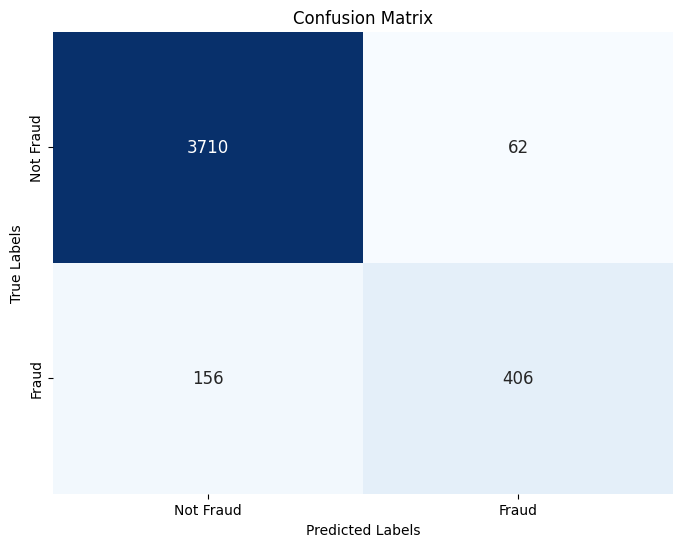

############################################################
                                                             Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3772
           1       0.87      0.72      0.79       562

    accuracy                           0.95      4334
   macro avg       0.91      0.85      0.88      4334
weighted avg       0.95      0.95      0.95      4334



In [24]:
# Compute the confusion matrix
cm = confusion_matrix(test_data['is_fraud'], test_data['prediction'])

# Define labels for the classes
labels = ["Not Fraud", "Fraud"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("#" * 60)
print(" " * 60, "Classification Report")
print(classification_report(test_data['is_fraud'], test_data['prediction']))

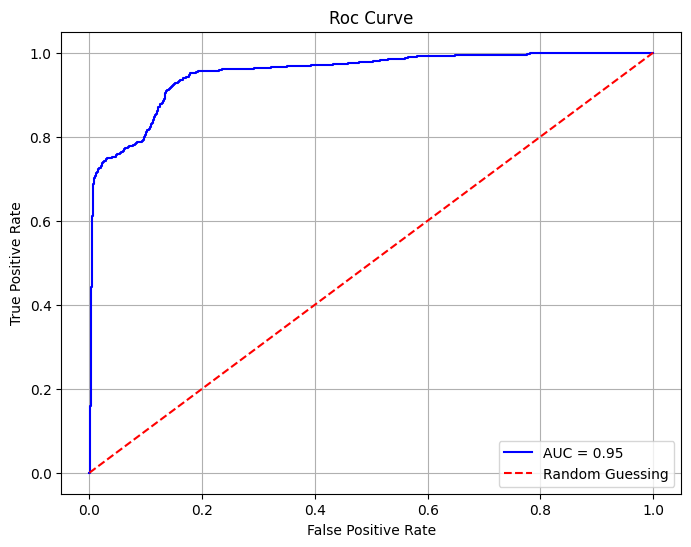

In [25]:
preds = log_reg.predict(test_data)
y_pred_proba = 1 / (1 + np.exp(-preds))

fpr, tpr, _ = roc_curve(test_data['is_fraud'], y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Gradient Boosted Random Forest for Fraud Prediction

In [26]:
#creating a new dataframe for the Random Forest
dftree = df[['is_fraud', 'merchant', 'category', 'amt', 'city_pop', 'age', 'hour', 'day_of_week', 'distance_km', 'professions']].copy()
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
dftree['merchant'] = le.fit_transform(dftree['merchant'])
dftree['category'] = le.fit_transform(dftree['category'])
dftree['day_of_week'] = le.fit_transform(dftree['day_of_week'])
dftree['professions'] = le.fit_transform(dftree['professions'])
dftree['hour'] = le.fit_transform(dftree['hour'])


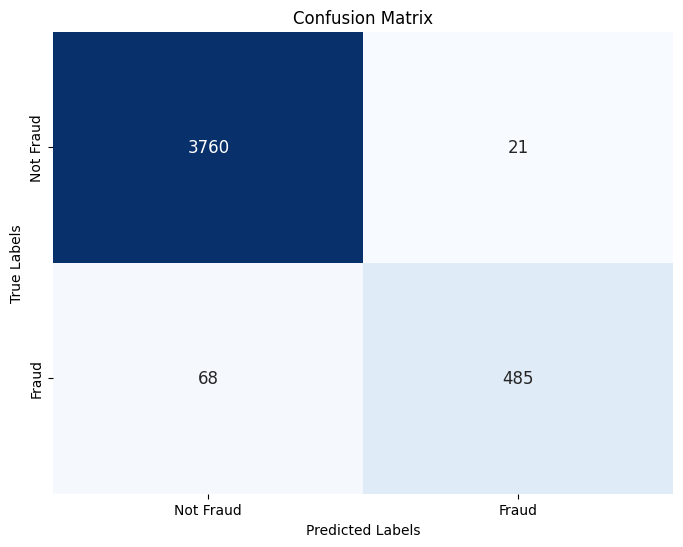

############################################################
                     Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3781
           1       0.96      0.88      0.92       553

    accuracy                           0.98      4334
   macro avg       0.97      0.94      0.95      4334
weighted avg       0.98      0.98      0.98      4334



In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Splitting the dataset into train and test sets
X = dftree.drop(columns=['is_fraud'])  # Features
y = dftree['is_fraud']                # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Random Forest with class weight to handle imbalanced classes
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # For AUC-ROC score


# Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)
# Define labels for the classes
labels = ["Not Fraud", "Fraud"]
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("#" * 60)
print(" " * 20, "Classification Report")
print(classification_report(y_test, y_pred))

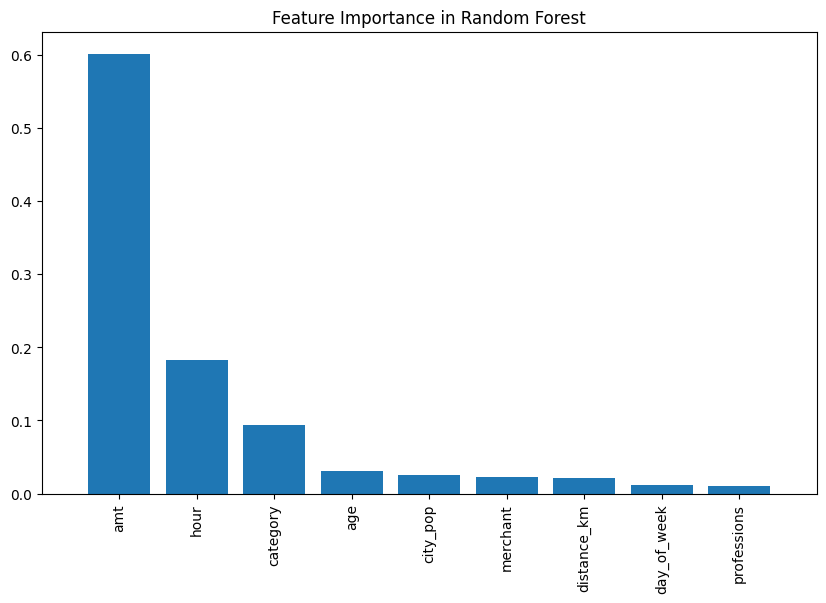

In [28]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [29]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


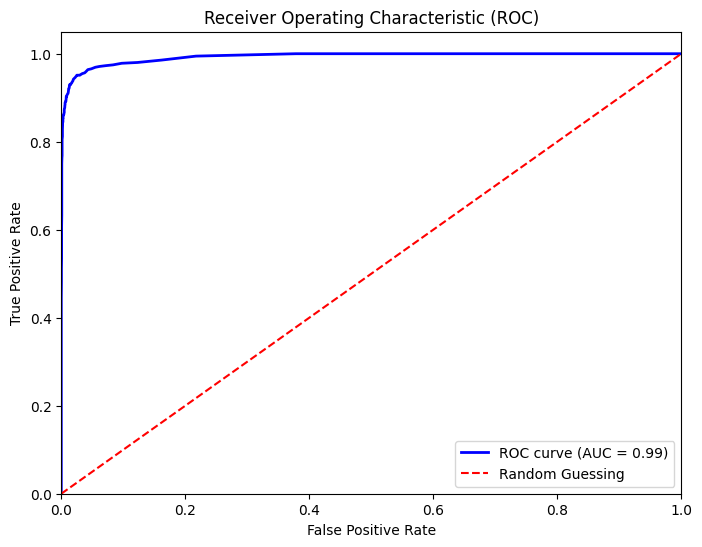

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [31]:
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

# Print each fold's AUC score and the average
print("AUC scores for each fold:", scores)
print("Mean AUC score:", scores.mean())

AUC scores for each fold: [0.99326849 0.99105637 0.99604196 0.99096496 0.99016617]
Mean AUC score: 0.9922995910762678
